In [52]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from tqdm import tqdm

pd.set_option("display.max_columns", None)
PATH = "C:/Users/jackl/OneDrive/Documents/finance_research/japan_qe/"

def get_qtr_index(sue_df, date_column): 
    sue_df['year'] = sue_df[date_column].apply(lambda x: x.year)
    sue_df['qtr'] = sue_df[date_column].apply(lambda x: x.quarter)

    fpe_year_list = list(sue_df['year'].astype(str)) 
    fpe_qtr_list = list(sue_df['qtr'].astype(str))
    qtr_year_list = [fpe_year_list[i] + 'Q' + fpe_qtr_list[i] for i in tqdm(range(len(fpe_year_list)))]

    sue_df['qtr_year_str'] = qtr_year_list
    qtr_dict = dict(zip(sorted(list(sue_df['qtr_year_str'].unique())), [i for i in range(len(list(sue_df['qtr_year_str'].unique())))]))
    sue_df['qtr_index'] = sue_df['qtr_year_str'].apply(lambda x: qtr_dict[x])
    
    sue_df = sue_df.drop(columns=['year', 'qtr'])
    
    return sue_df

def get_truncated_df(merge_df, columns, year_column_name=None, low=0.01, high=0.99):
    merge_df_copy = merge_df.copy()
    if year_column_name == None:
        for column in columns: 
            _1pct, _99pct = merge_df_copy[column].quantile(q=low), merge_df_copy[column].quantile(q=high)
            merge_df_copy[column].where((merge_df_copy[column] < _99pct) & (merge_df_copy[column] > _1pct), math.nan, inplace=True)
    else: 
        merge_df_list = []
        merge_year_df_list = [[year, merge_year_df] for year, merge_year_df in merge_df_copy.groupby(year_column_name)]
        for year, merge_year_df in tqdm(merge_year_df_list):
            for column in columns: 
                _1pct, _99pct = merge_year_df[column].quantile(q=low), merge_year_df[column].quantile(q=high)
                merge_year_df[column].where(~((merge_year_df[column] > _99pct) | (merge_year_df[column] < _1pct)), math.nan, inplace=True)
            merge_df_list.append(merge_year_df)
        merge_df_copy = pd.concat(merge_df_list)
    
    return merge_df_copy

def get_boj_quintiles_conditional(sue_df_boj_merged, column, suffix=None, quantiles=5):
    sue_df_boj_merged_nd = sue_df_boj_merged[['sedol', column, 'boj_share_shares']].drop_duplicates()
    sue_df_boj_merged_nd_list = []
    for index, df in tqdm(sue_df_boj_merged_nd.groupby(column)): 
        try:
            df['boj_share_shares_quantiles_'+suffix] = pd.qcut(df['boj_share_shares'], quantiles, labels=False)
        except: 
            df['boj_share_shares_quantiles_'+suffix] = [math.nan for i in range(len(df))]

        sue_df_boj_merged_nd_list.append(df)

    sue_df_boj_merged_nd = pd.concat(sue_df_boj_merged_nd_list)

    sue_df_boj_merged = pd.merge(sue_df_boj_merged, 
                                 sue_df_boj_merged_nd, 
                                 on=['sedol', column, 'boj_share_shares'])
    return sue_df_boj_merged

In [53]:
_alphabet = '0123456789 BCD FGH JKLMN PQRST VWXYZ'
def calc_check_digit(number):
    weights = (1, 3, 1, 7, 3, 9)
    s = sum(w * _alphabet.index(n) for w, n in zip(weights, number))
    return str((10 - s) % 10)
pd.set_option('display.max_columns', None)

In [54]:
boj_df = pd.read_pickle(PATH+'checkpoint_data/boj_purchases_stock_level_v2.pkl')

In [55]:
sue_df = pd.read_csv(PATH+'raw_data/ibes/full_summary_int.csv', parse_dates=['STATPERS', 'FPEDATS', 'ANNDATS_ACT'])
sue_df = sue_df[sue_df['FPI']==1]

In [56]:
control_df = pd.read_pickle(PATH+'checkpoint_data/control_yearly.pkl')
control_df = control_df.sort_values(['sedol', 'yr'])

## Merge

In [57]:
sue_df = sue_df[sue_df['FPEDATS'] >= pd.to_datetime('2010-12-10')]
sue_df = sue_df[sue_df['CURCODE']=='JPY']
sue_df = sue_df.sort_values(['CUSIP', 'STATPERS'])
sue_df = sue_df.drop_duplicates(['ANNDATS_ACT', 'CUSIP'], keep='last')

#get SEDOL from ISIN
sue_df['sedol'] = sue_df['CUSIP'].apply(lambda x: str(x)[2:] if len(str(x)) == 8 else math.nan)
sue_df['sedol'] = sue_df['sedol'].apply(lambda x: str(x) + calc_check_digit(x) if len(str(x)) == 6 else math.nan)

In [58]:
sue_df['yr'] = sue_df['ANNDATS_ACT'].dt.year
sue_df = sue_df.sort_values(['sedol', 'FPEDATS'])
sue_df = sue_df.drop_duplicates(['sedol', 'yr'], keep='last')

In [59]:
sue_df = sue_df.dropna(subset=['yr'])

In [60]:
sue_df_reindexed_list = []
for sedol, df in tqdm(sue_df.groupby(['sedol'])):
    year_list = sorted(list(df['yr']))
    first_year, last_year = year_list[0], year_list[-1]
    
    full_year_index = []
    year = first_year
    while year <= last_year: 
        full_year_index.append(year)
        year += 1
    
    df = df.set_index(['yr'])
    df = df.reindex(full_year_index)
    df = df.reset_index()
    df['NUMEST'] = df['NUMEST'].fillna(0)
    df['sedol'] = sedol
    sue_df_reindexed_list.append(df)

sue_df_reindexed = pd.concat(sue_df_reindexed_list).reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████████████████████| 2462/2462 [00:12<00:00, 196.67it/s]


In [61]:
boj_df['yr'] = boj_df['date'].dt.year
boj_df['yr_f1'] = boj_df['date'].dt.year + 1
boj_df = boj_df.sort_values(['sedol', 'date'])
boj_df = boj_df.drop_duplicates(['yr', 'sedol'], keep='last')
boj_df = boj_df.drop(columns=['yr_qtr_index', 'yr_qtr_index_f1'])

In [62]:
sue_df_merged_1 = pd.merge(sue_df_reindexed, 
                           boj_df.drop(columns=['yr']), 
                           left_on=['sedol', 'yr'],
                           right_on=['sedol', 'yr_f1'],
                           how='left').drop(columns=['yr_f1'])

In [63]:
sue_df_merged_2 = pd.merge(sue_df_merged_1, 
                           control_df, 
                           on=['sedol', 'yr'], 
                           how='left')

In [64]:
sue_df_merged_2.to_stata(PATH+'regression_files/dta_files/num_analysts_regression_yearly.dta')

# Exploration

In [65]:
nk_sue_df = sue_df_merged_2[sue_df_merged_2['nk_flag']==1]
nk_sue_df = get_boj_quintiles_conditional(nk_sue_df, column='yr', suffix='nk', quantiles=10)

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 239.76it/s]


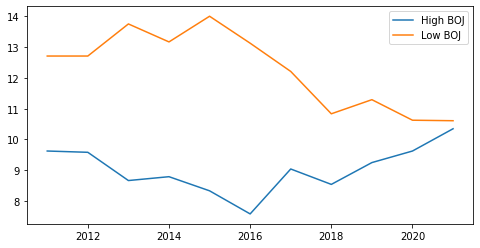

In [66]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
plt.plot(nk_sue_df[nk_sue_df['boj_share_shares_quantiles_nk'].isin([9])].groupby(['yr'])['NUMEST'].mean(), 
         label='High BOJ')
plt.plot(nk_sue_df[nk_sue_df['boj_share_shares_quantiles_nk'].isin([0])].groupby(['yr'])['NUMEST'].mean(), 
         label='Low BOJ')

# plt.plot(nk_sue_df.groupby(['yr'])['NUMEST'].mean(), 
#          label='Mean')

plt.legend()

In [104]:
nk_sue_df.to_stata(PATH+'regression_files/dta_files/num_analysts_regression.dta')